## KMSurvival in Jupyter Notebook

We're going to create survival estimates using `KMSurvival` on the same subscribers data as in SAS above. Then we'll compare both estimates to see if they are equal. After that, more comparisions on hierarchical strata are given.

In [1]:
import pandas as pd
from kmsurvival import KMSurvival, plot_right_censor

pd.set_option('precision', 3)
%matplotlib inline

In [2]:
df = pd.read_csv('censored_start_stop.txt', sep='\t', 
                 parse_dates=['start_date', 'stop_date'])
df.head()

,user_id,market,channel,start_date,stop_date,censored
0,2488577,Market-B,Channel-C3,2008-03-28,NaT,1
1,2574285,Market-A,Channel-C1,2008-05-12,NaT,1
2,2565957,Market-B,Channel-C2,2008-05-07,NaT,1
3,2201921,Market-B,Channel-C3,2007-12-11,NaT,1
4,2776956,Market-A,Channel-C2,2008-09-18,NaT,1


In [3]:
kms = KMSurvival(col_censored = 'censored',
                 col_start_date='start_date',
                 col_stop_date='stop_date')

In [4]:
cutoff = '2008-12-28'
estimates = kms.fit(df, cutoff)
estimates.head()

estimates_,survival,hazard,cnt_uncensored,cnt_censored,cutoff
_tenure_,,,,,
1,0.994,0.006,4,0,2008-12-28
2,0.987,0.007,5,1,2008-12-28
3,0.986,0.001,1,0,2008-12-28
4,0.982,0.004,3,1,2008-12-28
5,0.979,0.003,2,4,2008-12-28


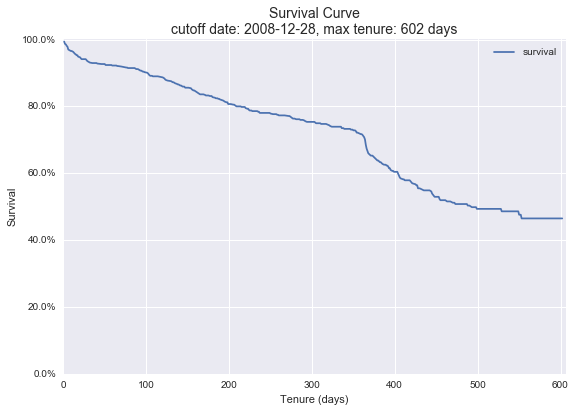

In [5]:
kms.plot()

In [6]:
# For comparing with the output of SAS PROC LIFETEST
estimates.to_csv('km_estimates_py.csv', header=True, 
                 index_label='tenure', float_format='%.6f')

### Compare survival estimates between SAS and KMSurvival

We use the same subscribers data and create survival estimates using SAS `PROC LIFETEST` and `KMSurvial`. Now let's see if both are equal.

In [7]:
class Display(object):
    """Display multiple objects horizontally"""    
    template = """<div style="float: left; padding: 6px;">
                  <p>{0}</p><font size=2>{1}</font></div>
               """
    
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

In [8]:
df_sas = pd.read_sas("survival.sas7bdat")  # read SAS survival estimates
df_py = pd.read_csv("km_estimates_py.csv") # read KMSurvial estimates

In [9]:
Display('df_sas.head()', 'df_py.head()')

In [10]:
df_sas[df_sas['_CENSOR_'].isnull()]

,tenure,_CENSOR_,SURVIVAL,SDF_LCL,SDF_UCL
0,0.0,NaN,1.0,1.0,1.0


For df_sas:

* drop the row whose \_CENSOR\_ is missing
* rename columns
* drop the the last two columns (95% confidence intervals)

For df_py:

* keep columns 'tenure', 'survival', and drop others

In [11]:
df_sas = df_sas[df_sas['_CENSOR_'].notnull()]
df_sas.rename(columns={'SURVIVAL': 'survival', '_CENSOR_': 'censor'}, 
              inplace=True)
df_sas = df_sas[['tenure', 'survival', 'censor']]

df_py = df_py[['tenure', 'survival']]
Display('df_sas.head(3)', 'df_py.head(3)')

In [12]:
print(df_sas.shape, df_py.shape)

(637, 3) (392, 2)


The differences are probably because SAS's estimates include the 'censor' column. Let's try these:

* Find if survivals for the same tenures but different censors are equal. 
* If so, we can drop the column 'censor'.


In [13]:
grp_sas = df_sas.groupby(['tenure'])
for tenure, group in grp_sas:  # group is a DataFrame
    if len(group) > 1:
        if group['survival'].unique().size == 1:
            continue
        else:
            print('Found multiple survival estimates for a tenure!\n'
                  'Tenure:{}\n{}'.format(tenure, group))


Found multiple survival estimates for a tenure!
Tenure:553.0
     tenure  survival  censor
595   553.0     0.465     0.0
596   553.0       NaN     1.0


There's one outlier! It seems safe to drop the row with missing value (index 596).

In [14]:
df_sas.index.get_loc(596)

595

In [15]:
df_sas.drop(596, inplace=True)

In [16]:
df_sas.drop(['censor'], axis=1, inplace=True)

In [17]:
Display('df_sas.head()', 'df_py.head()', 'df_sas.tail()', 'df_py.tail()')

,tenure,survival
1,1.0,0.994
2,2.0,0.987
3,2.0,0.987
4,3.0,0.986
5,4.0,0.982
,tenure,survival
0,1,0.994
1,2,0.987
2,3,0.986
3,4,0.982


Check missing values

In [18]:
df_sas[df_sas.survival.isnull()].index

Int64Index([597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609,
            610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622,
            623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635,
            636, 637],
           dtype='int64')

In [19]:
df_py[df_py.survival.isnull()].index

Int64Index([], dtype='int64')

We can see:
* df_py: no missing values
* df_sas: the survival values are missing since index 597. Let's check a few values before it.


In [20]:
df_sas.ix[593:598]

,tenure,survival
593,552.0,0.476
594,552.0,0.476
595,553.0,0.465
597,554.0,NaN
598,556.0,NaN



Let's take a look at the survival curve created by SAS.

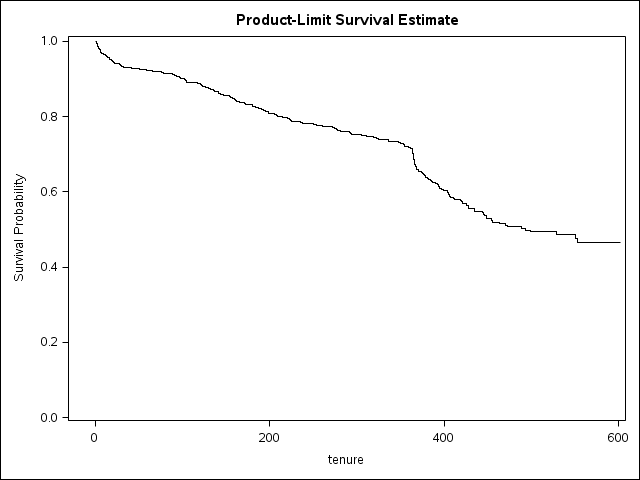

In [21]:
from IPython.display import Image
Image(filename='SAS_SurvivalPlot.png')

We see the tail is flat, which means the survival values of index from 597 to 637 equal to index 595's. So we do these:

* forward-fill these missing values
* then drop duplicate rows


In [22]:
df_sas.ix[:, 'survival'].fillna(method='ffill', inplace=True)
df_sas.drop_duplicates(inplace=True)

In [23]:
Display('df_sas.head(3)', 'df_py.head(3)', 'df_sas.tail(3)', 'df_py.tail(3)')

,tenure,survival
1,1.0,0.994
2,2.0,0.987
4,3.0,0.986
,tenure,survival
0,1,0.994
1,2,0.987
2,3,0.986
,tenure,survival
632,598.0,0.465
634,601.0,0.465


In [24]:
print(df_sas.shape, df_py.shape)

(392, 2) (392, 2)


The two look like much similar now. Let's tune them a little more.

In [25]:
df_sas['tenure'] = df_sas.tenure.astype(int)
df_py.set_index('tenure', inplace=True)
df_sas.set_index('tenure', inplace=True)

In [26]:
Display('df_sas.head(3)', 'df_py.head(3)', 'df_sas.tail(3)', 'df_py.tail(3)')

,survival
tenure,
1,0.994
2,0.987
3,0.986
,survival
tenure,
1,0.994
2,0.987
3,0.986
,survival


They are much alike now. Let's check it.

In [27]:
print("Indices equal? -- {}\n"      
      "Survival values equal? -- {}".format(
        df_sas.index.equals(df_py.index),
        df_sas['survival'].equals(df_py['survival'])))

Indices equal? -- True
Survival values equal? -- False


Why not equal? Probably it's because of very small differences between float values.

In [28]:
diff = (df_sas - df_py); diff.columns = ['survival_diff']
diff.head(3)

,survival_diff
tenure,
1,-9.818e-08
2,2.791e-07
3,-2.405e-07


Let's assume if the difference of two values is less than 1E-6, we say they're equal.

In [29]:
threshold = 1e-6 
if (diff < threshold).all().values:
    print('Survial estimates from SAS and KMSurvival are equal!')
else:
    print('Not euqal!')

Survial estimates from SAS and KMSurvival are equal!


### Qualitative comparisions

We've compared the two quantatively by data exploring and cleaning. Now let's compare them qualitatively.

KM estimation can be used to compare different groups of customers by creating a separate curve for each group. This process, called stratification, qualitatively shows the effect of different factors, or a combination of them, on survival.

#### One-level strata

Compare the subscribers' survivals in different markets.

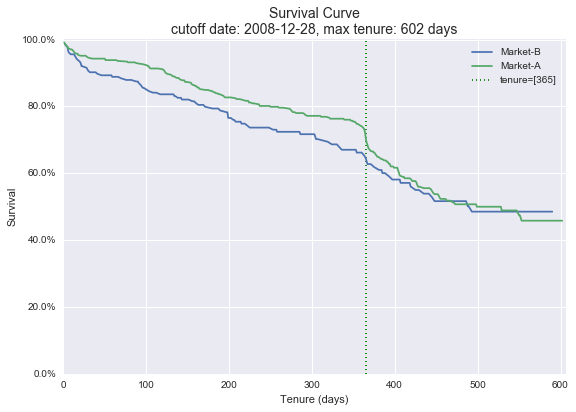

In [30]:
# KMSurvival
cutoff = '2008-12-28'
group = ['market']
kms.fit(df, cutoff, group)
kms.plot(vlines=[365])

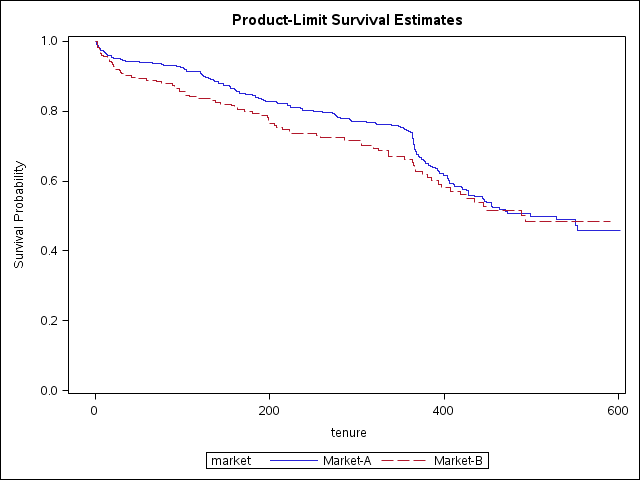

In [31]:
# SAS
Image(filename='SAS_SurvivalPlot_market.png')

<br>
From the survival curves we can see the product performs better at Market-A than at Market-B, and Market-A's subscriptions drop dramtically at tenure 365 days.
<br>

#### Two-level hierarchical strata

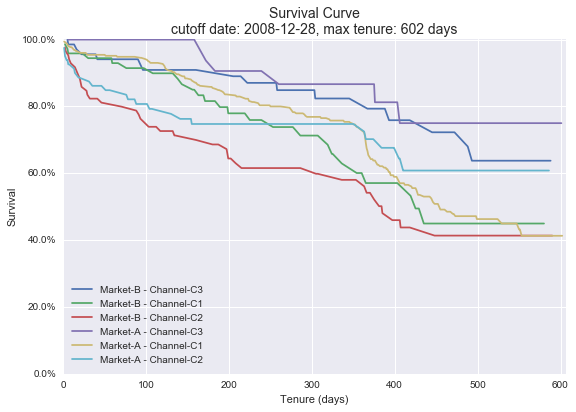

In [32]:
# KMSurvial
group = ['market', 'channel']
kms.fit(df, cutoff, group)
kms.plot()

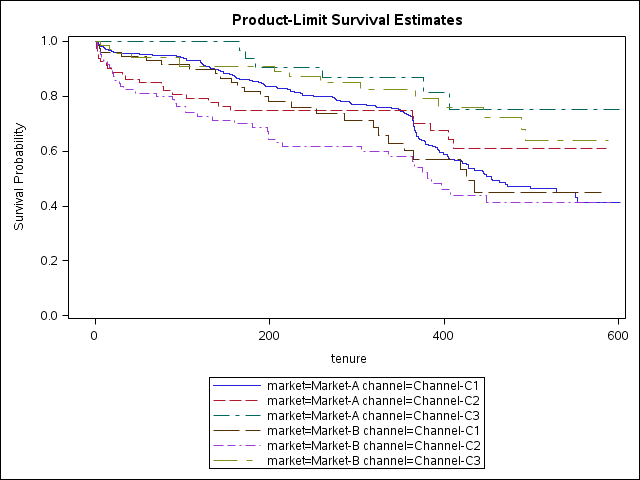

In [33]:
# SAS
Image(filename='SAS_SurvivalPlot_market_channel.png')

The figures from SAS and KMSurvival look like very similar.

### Flexible combinations of strata

Now let's do something that SAS doesn't support. Suppose we only want to compare Channel-C2, Channel-C3 of Market-A.

In [34]:
kms.subgrps_

OrderedDict([('market', ('Market-B', 'Market-A')),
             ('channel', ('Channel-C3', 'Channel-C1', 'Channel-C2'))])

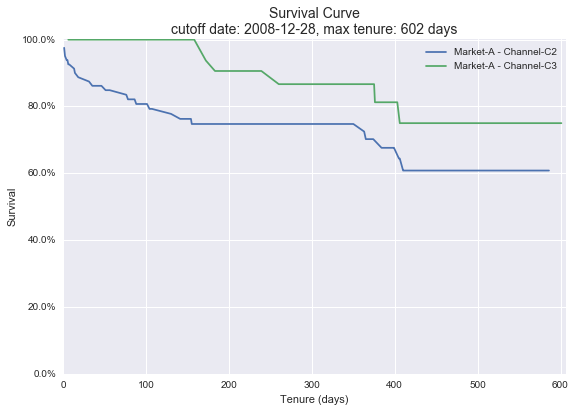

In [35]:
kms.plot(strata=[['Market-A'], ['Channel-C2', 'Channel-C3']])

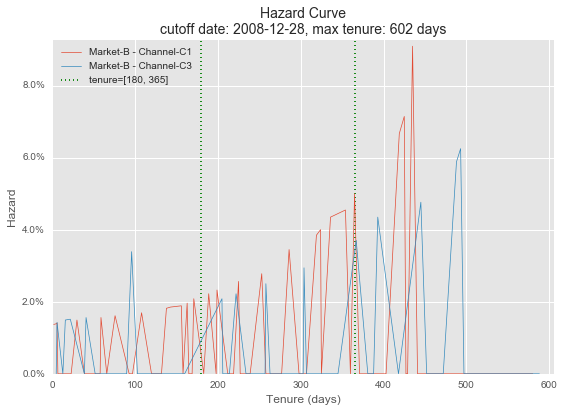

In [36]:
# hazard curve of Channel-C3 and Channel-C1 in Market-B
kms.plot(curve='h', strata=[['Market-B'], ['Channel-C1', 'Channel-C3']],
         style='ggplot', vlines=[180, 365], lw=0.7)

---

### Summary

We have compared between `PROC LIFETEST` and `KMSurvival` in Jupyter Notebook. The output of the two is almost same. And we can see Jupyter Notebook is great for packaging code, results and documentations in the notebook format. It also makes sharing the process of data analysis more convenient.

<br>
Thank for reading!